In [ ]:
import sys

if True:
    # !pip install -U "jax[cuda12]"
    %pip install jaxkan --no-deps
    %pip install tqdm

if True:
    """
    import os
    os.environ['XLA_FLAGS'] = (
        '--xla_gpu_enable_triton_softmax_fusion=true '
        '--xla_gpu_triton_gemm_any=True '
        '--xla_gpu_enable_async_collectives=true '
        '--xla_gpu_enable_latency_hiding_scheduler=true '
        '--xla_gpu_enable_highest_priority_async_stream=true '
    )
    """
#    sys.path.append('/kaggle/input/utilspikan')

from flax import linen as nn
from flax.training import train_state
from flax.linen.initializers import glorot_normal
from typing import Callable

import jax
import jax.numpy as jnp
import numpy as np
import optax

from jaxkan.models.KAN import KAN

from tqdm import tqdm
import matplotlib.pyplot as plt

jax.devices()

[CpuDevice(id=0)]

In [2]:
from Utils import *

class Config:
    N_INPUT = 2
    
    X_MIN = -1
    X_MAX = 1
    
    Y_MIN = -1
    Y_MAX = 1
    
    BS = 2**12 #14
    BS_BC = 1024
    EPOCHS = round(0.25*10000) # 2 * 10000
    
    MODEL = 'MLP'
    layer_dims = [N_INPUT, 7, 7, 1]
    
    HIDDEN_UNITS = 64
    FourierFeatures = True
    
r = KeyHandler(0)

In [3]:
def get_mse_loss(model, MODEL='MLP'):
    @jax.jit
    def mse_loss_mlp(params, x, y, state, loc_w):
        def u(vec_x, variables):
            y = model.apply(variables, vec_x)
            return y
        variables = {'params' : params}
        
        y_hat = u(x, variables)
        loss = jnp.mean((y_hat - y)**2)

        new_loc_w = loc_w
        return loss, new_loc_w

    if MODEL == 'MLP':
        return mse_loss_mlp
    
    @jax.jit
    def mse_loss_kan(params, x, y, state, loc_w):
        def u(vec_x, variables):
            y, _ = model.apply(variables, vec_x)
            return y
        variables = {'params' : params, 'state': state}
        
        y_hat = u(x, variables)
        loss = jnp.mean((y_hat - y)**2)

        new_loc_w = loc_w
        return loss, new_loc_w
    
    if MODEL == 'KAN':
        return mse_loss_kan
    
def get_train_step(model, optimizer, loss_fn):
    @jax.jit
    def train_step(params, x, y, opt_state, state, loc_w):
        # Compute gradients and loss
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, new_loc_w), grads = grad_fn(params, x, y, state, loc_w)

        # Update parameters using optimizer
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return params, opt_state, loss, new_loc_w

    return train_step

class FourierFeats(nn.Module):
    num_output: int
    
    std = 10
    mean = 0
    
    @nn.compact
    def __call__(self, x):
        B = self.param(
            'B', lambda rng, shape: self.mean + jax.random.normal(rng, shape) * self.std,
           (x.shape[-1],self.num_output//2)
        )
        bias = self.param(
            'bias', lambda rng, shape: jax.random.normal(rng, shape)*0,
            (self.num_output//2,)
        )
        
        x = jnp.matmul(x,B)
        # 2*jnp.pi*
        x = jnp.concatenate([jnp.cos((x+bias)), jnp.sin((x+bias))], axis=-1)
            
        return x

# Defining the MLP_fourier model initialization
glorot = nn.initializers.glorot_normal()
class MLP_fourier(nn.Module):
    kernel_init: Callable
    num_input: int
    num_hidden: int
    num_output: int

    @nn.compact
    def __call__(self, x):
        x = FourierFeats(self.num_hidden)(x)

        # Hidden layers with Tanh activations
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)

        # Final output layer
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x
    
# Defining the MLP_fourier model initialization
glorot = nn.initializers.glorot_normal()
class MLP(nn.Module):
    kernel_init: Callable
    num_input: int
    num_hidden: int
    num_output: int

    @nn.compact
    def __call__(self, x):
        # Hidden layers with Tanh activations
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)

        # Final output layer
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x

In [4]:
from flax import linen as nn
import jax
import jax.numpy as jnp

# Assuming KAN is a model class, we define a Flax wrapper around it.
class FourierKAN(nn.Module):
    layer_dims: list
    k: int
    add_bias: bool
    B: jnp.array

    @nn.compact
    def __call__(self, x):
        # Instantiate the KAN model inside the compact method.
        model = KAN(
            layer_dims=self.layer_dims, 
            k=self.k, 
            add_bias=self.add_bias
        )
        # Fourier feature embeddings
        x = jnp.matmul(x,self.B.T)  # Apply the Fourier feature matrix
        x = jnp.concatenate([jnp.cos(x), jnp.sin(x)], axis=-1)
        y, spl_regs = model(x)
        
        return y, spl_regs

In [5]:
def sample_collocs():
    # sample outside
    collocs = jnp.array(sobol_sample(np.array([Config.X_MIN,Config.Y_MIN]), 
                                     np.array([Config.X_MAX,Config.Y_MAX]), Config.BS))
    return collocs

collocs = sample_collocs()

In [6]:
if Config.MODEL == 'MLP':
    def u(vec_x, variables):
        y = model.apply(variables, vec_x)
        return y

    std = 5
    B = jax.random.normal(r.key(), (Config.HIDDEN_UNITS,2)) * std

    if Config.FourierFeatures:
        model = MLP_fourier(
            kernel_init=glorot,
            num_input=Config.N_INPUT,
            num_hidden=Config.HIDDEN_UNITS,
            num_output=1,
       #     B=B
        )
    else:
        model = MLP(
            kernel_init=glorot,
            num_input=Config.N_INPUT,
            num_hidden=Config.HIDDEN_UNITS,
            num_output=1,
        )
        
    variables = model.init(r.key(), collocs)
    loss_fn = get_mse_loss(model, MODEL='MLP')

In [7]:
if Config.MODEL == 'KAN':
    def u(vec_x, variables):
        y, _ = model.apply(variables, vec_x)
        return y
    
    if Config.FourierFeatures:
        expansion = 3
        std = 5
        B = jax.random.normal(r.key(), (expansion,2)) * std

        Config.layer_dims = [expansion*2,7,7,1]
        model = FourierKAN(
        layer_dims=Config.layer_dims, 
            k=3, 
            add_bias=True,
            B=B
        )
        variables = model.init(r.key(), collocs)
#        y, spl_regs = model.apply(variables, collocs)
        loss_fn = get_mse_loss(model, MODEL='KAN') 
    else:
        model = KAN(
            layer_dims=Config.layer_dims, 
            k=3, 
            add_bias=True
        )
        variables = model.init(r.key(), collocs)

        loss_fn = get_mse_loss(model, MODEL='KAN')

In [8]:
# Define a cosine decay learning rate schedule
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,       # Initial learning rate
    decay_steps=Config.EPOCHS,  # Total number of decay steps
    alpha=1e-3             # Final learning rate multiplier
)

optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
opt_state = optimizer.init(variables['params'])
train_step = get_train_step(model, optimizer, loss_fn)

In [9]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

def compute_and_plot_frequencies(input_array, N, title="Frequency Spectrum"):
    """
    Computes the 2D FFT of an input array, shifts the zero-frequency component to the center,
    computes the magnitude spectrum, and plots it.

    Parameters:
    - input_array: A 1D or 2D JAX array of shape (N*N,) or (N, N).
    - N: Integer, size of one dimension (input reshaped to (N, N)).
    - title: String, title for the plot.

    Returns:
    - None, but displays the plot of the magnitude spectrum.
    """
    # Reshape to 2D array if needed
    if input_array.ndim == 1:
        input_array = input_array.reshape(N, N)
    
    # Perform 2D FFT
    fft_result = jnp.fft.fft2(input_array)
    
    # Shift zero-frequency component to the center
    fft_shifted = jnp.fft.fftshift(fft_result)
    
    # Compute magnitude spectrum
    magnitude = jnp.abs(fft_shifted)
    
    # Plotting the magnitude spectrum
    plt.figure(figsize=(6, 6))
    plt.imshow(jnp.log1p(magnitude), cmap='viridis', extent=(-N/2, N/2, -N/2, N/2))
    plt.title(title)
    plt.xlabel('Frequency X')
    plt.ylabel('Frequency Y')
    plt.colorbar(label='Log Magnitude')
    plt.grid(False)
    plt.show()

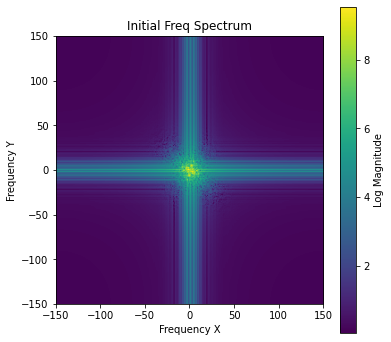

In [10]:
N = 300
X_1 = jnp.linspace(Config.X_MIN, Config.X_MAX, N)
X_2 = jnp.linspace(Config.Y_MIN, Config.Y_MAX, N)
X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)

y_hat = u(coords, variables).reshape(N,N)
compute_and_plot_frequencies(y_hat, N, title="Initial Freq Spectrum")

In [11]:
import jax
import jax.numpy as jnp

FREQ = 10
# Function to test interpolation
@jax.jit
def oscillatory_sine(x):
    y = jnp.sin(FREQ * jnp.pi * x[:, 0]) * jnp.cos(FREQ * jnp.pi * x[:, 1])
    return y

@jax.jit
def radial_oscillation(x):
    r = jnp.sqrt((x[:, 0] - 1)**2 + (x[:, 1] - 1)**2)
    y = jnp.sin(FREQ * jnp.pi * r)
    return y

@jax.jit
def discontinuous_starburst(x):
    theta = jnp.arctan2(x[:, 1] - 1, x[:, 0] - 1)
    y = jnp.where(jnp.mod(theta * FREQ, 2 * jnp.pi) > jnp.pi, 1.0, -1.0)
    return y

@jax.jit
def ring_function(x):
    y = jnp.sin(FREQ * jnp.pi * jnp.sqrt((x[:, 0] - 1)**2 + (x[:, 1] - 1)**2))
    return y

@jax.jit
def modulated_gaussian(x):
    y = jnp.exp(-((x[:, 0] - 1)**2 + (x[:, 1] - 1)**2)) * \
        jnp.sin(FREQ * jnp.pi * x[:, 0]) * jnp.cos(FREQ * jnp.pi * x[:, 1])
    return y

@jax.jit
def circular_wave_interference(x):
    r1 = jnp.sqrt((x[:, 0] - 0.5)**2 + (x[:, 1] - 0.5)**2)
    r2 = jnp.sqrt((x[:, 0] - 1.5)**2 + (x[:, 1] - 1.5)**2)
    y = jnp.sin(FREQ * jnp.pi * r1) + jnp.sin(FREQ * jnp.pi * r2)
    return y

In [12]:
loc_w = jnp.array([])

In [13]:
%%time
learnable_func = circular_wave_interference

grid_adaption = {}

if len(variables) == 1:
    variables["state"] = []
    
# train always on same colloc points
collocs = sample_collocs()
losses = []

for i in (pbar:= tqdm(range(Config.EPOCHS))):
    params, state = variables['params'], variables['state']
    y = learnable_func(collocs).reshape(-1,1)
    params, opt_state, loss, loc_w = train_step(params, collocs, y,
                                                opt_state, state, loc_w)
    variables = {'params': params, 'state':state}
        
    losses.append(loss)
    
    if i % 50 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .8f}")

Loss  0.00006895: 100%|██████████| 2500/2500 [00:23<00:00, 107.70it/s]

CPU times: user 53.2 s, sys: 5.76 s, total: 59 s
Wall time: 23.2 s


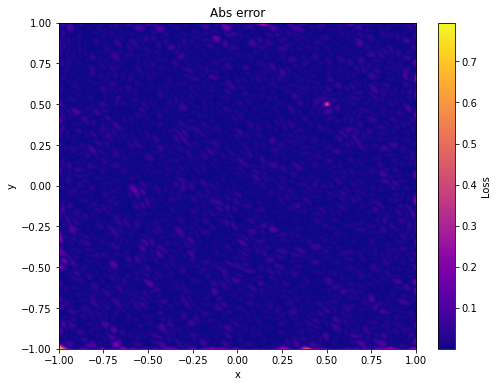

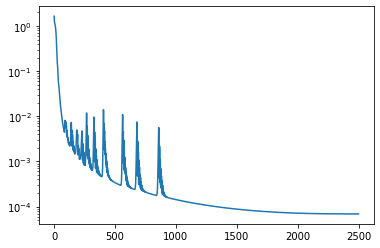

In [14]:
def plot_heatmap(arr, title):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(Config.X_MIN, Config.X_MAX, Config.Y_MIN, Config.Y_MAX), 
               origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

N = 300

X_1 = jnp.linspace(Config.X_MIN, Config.X_MAX, N)
X_2 = jnp.linspace(Config.Y_MIN, Config.Y_MAX, N)
X_1, X_2 = jnp.meshgrid(X_1, X_2, indexing='ij')
coords = jnp.stack([X_1.flatten(), X_2.flatten()], axis=1)
y = learnable_func(coords).reshape(-1,1)

if Config.MODEL == 'MLP':
    y_hat = u(coords, {'params': variables["params"]})
else:
    y_hat = u(coords, variables)
error = jnp.abs(y - y_hat).reshape(N, N)

plot_heatmap(error, "Abs error")
# plot_heatmap(error / (y.mean() + 1e-16), "Relative error")

"""
grid_extensions = {200: 5, 400: 10}
for index in grid_extensions.keys():
    plt.axvline(x=index, color='red', linestyle='--')
"""
# plt.plot(losses)
plt.semilogy(losses)

MODEL USED: 		MLP
FOURIER FEATURES: 	True


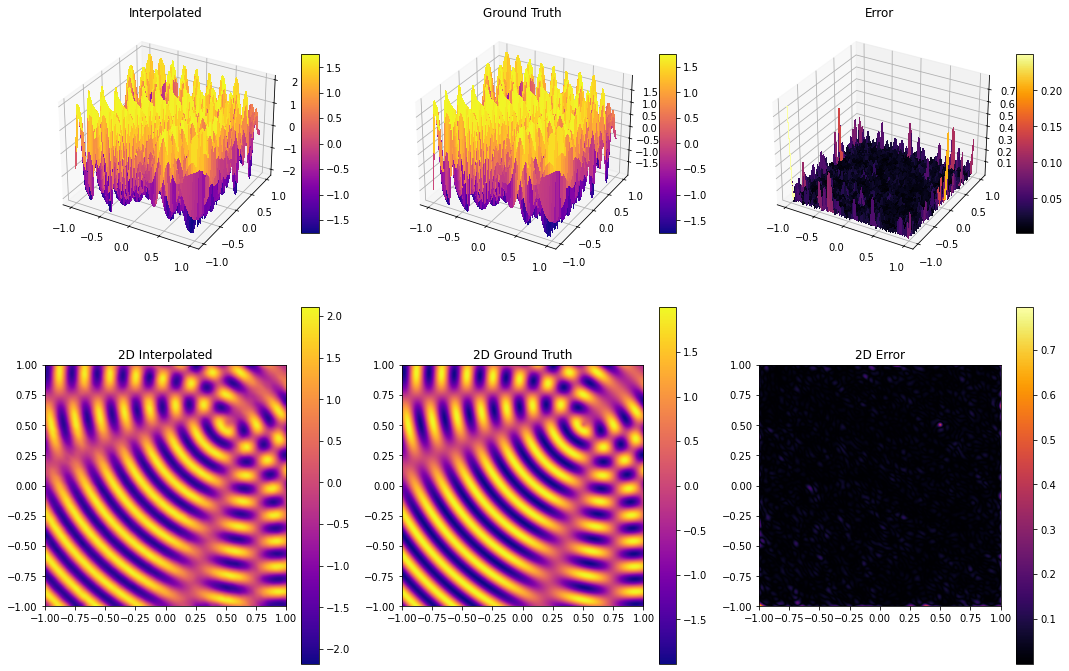

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot_3d_surfaces_with_2d(X_1, X_2, p1, p2, error=None, colloc_points=None, 
                             title1='Interpolated', title2='Ground Truth', title3='Error', figsize=(15, 10)):
    """
    Plots two 3D surface plots with their 2D projections and overlays collocation points.

    Parameters:
    - X_1: 2D array for X-axis values.
    - X_2: 2D array for Y-axis values.
    - p1: 2D array for Z-axis values of the first surface (e.g., interpolated values).
    - p2: 2D array for Z-axis values of the second surface (e.g., ground truth values).
    - error: Optional 2D array for Z-axis values of the error surface.
    - colloc_points: Optional tuple (X, Y, Z) of collocation points to overlay.
    - title1: Title for the first surface plot.
    - title2: Title for the second surface plot.
    - title3: Title for the error surface plot (if provided).
    - figsize: Size of the figure (width, height).
    """
    # Create a larger figure with multiple subplots
    fig = plt.figure(figsize=figsize)

    # 3D plot for p1
    ax1 = fig.add_subplot(231, projection='3d')
    surf1 = ax1.plot_surface(X_1, X_2, p1, cmap=cm.plasma, linewidth=0, antialiased=False)
    ax1.set_title(title1)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)


    # 3D plot for p2
    ax2 = fig.add_subplot(232, projection='3d')
    surf2 = ax2.plot_surface(X_1, X_2, p2, cmap=cm.plasma, linewidth=0, antialiased=False)
    ax2.set_title(title2)
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # Error plot if provided
    if error is not None:
        ax3 = fig.add_subplot(233, projection='3d')
        surf3 = ax3.plot_surface(X_1, X_2, error, cmap=cm.inferno, linewidth=0, antialiased=False)
        ax3.set_title(title3)
        fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    # Add 2D projections below each 3D plot
    ax4 = fig.add_subplot(234)
    im1 = ax4.imshow(p1, extent=(X_1.min(), X_1.max(), X_2.min(), X_2.max()), origin='lower', cmap=cm.plasma)
    ax4.set_title(f"2D {title1}")
    fig.colorbar(im1, ax=ax4)

    ax5 = fig.add_subplot(235)
    im2 = ax5.imshow(p2, extent=(X_1.min(), X_1.max(), X_2.min(), X_2.max()), origin='lower', cmap=cm.plasma)
    ax5.set_title(f"2D {title2}")
    fig.colorbar(im2, ax=ax5)

    if error is not None:
        ax6 = fig.add_subplot(236)
        im3 = ax6.imshow(error, extent=(X_1.min(), X_1.max(), X_2.min(), X_2.max()), origin='lower', cmap=cm.inferno)
        ax6.set_title(f"2D {title3}")
        fig.colorbar(im3, ax=ax6)

    plt.tight_layout()
    plt.show()


y = y.reshape(N, N)
y_hat = y_hat.reshape(N, N)

print(f"MODEL USED: \t\t{Config.MODEL}")
print(f"FOURIER FEATURES: \t{Config.FourierFeatures}")
plot_3d_surfaces_with_2d(X_1, X_2, y_hat, y, error, collocs)

In [16]:
def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err


print(f'L2 error {l2_error(y_hat, y)*100:.4f}%')

L2 error 2.4369%


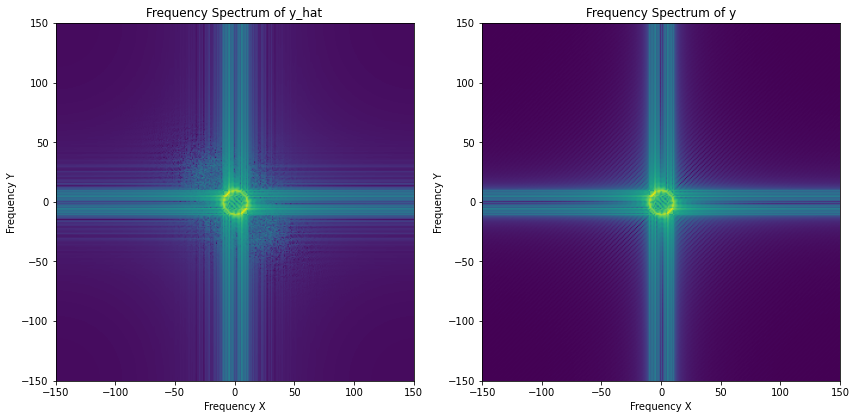

In [17]:
import jax.numpy as jnp
import matplotlib.pyplot as plt


# Assuming y_hat and y are given and reshaped into (N, N)
# Perform 2D FFT
fft_y_hat = jnp.fft.fft2(y_hat.reshape(N, N))
fft_y = jnp.fft.fft2(y.reshape(N, N))

# Shift zero-frequency component to the center
fft_y_hat_shifted = jnp.fft.fftshift(fft_y_hat)
fft_y_shifted = jnp.fft.fftshift(fft_y)

# Compute magnitude spectra
magnitude_y_hat = jnp.abs(fft_y_hat_shifted)
magnitude_y = jnp.abs(fft_y_shifted)

# Plotting the magnitude spectra
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(jnp.log1p(magnitude_y_hat), cmap='viridis', extent=(-N/2, N/2, -N/2, N/2))
axes[0].set_title('Frequency Spectrum of y_hat')
axes[0].set_xlabel('Frequency X')
axes[0].set_ylabel('Frequency Y')

axes[1].imshow(jnp.log1p(magnitude_y), cmap='viridis', extent=(-N/2, N/2, -N/2, N/2))
axes[1].set_title('Frequency Spectrum of y')
axes[1].set_xlabel('Frequency X')
axes[1].set_ylabel('Frequency Y')

plt.tight_layout()
plt.show()